# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The puddle world domain

Consider the puddleworld domain from the homework, depicted in the figure below.

<img src="puddleworld.png" width="400px">

In it, an all terrain vehicle must navigate a 20 &times; 20 gridworld. The three shaded cells in the upper right corner correspond to the goal state, while the L-shaped shaded cells in the middle of the grid correspond to a puddle in which the vehicle may get stuck and damaged. 

The vehicle has available the standard four actions, _up_, _down_, _left_ and _right_. Each action

* Succeeds and moves the vehicle to the adjacent cell in the corresponding direction with a probability of $0.92$; 
* Fails and moves the vehicle to any of the other 3 adjacent cells with a probability of $0.02$; 
* Fails and the vehicle remains in the same cell with a probability of $0.02$.

The vehicle incurs maximal cost ($1$) for standing in the darker part of the puddle; in the lighter part of the puddle, it incurs a cost of $0.5$. Each movement costs $0.05$ and the goal cells cost $0$.

The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

<IPython.core.display.Javascript object>


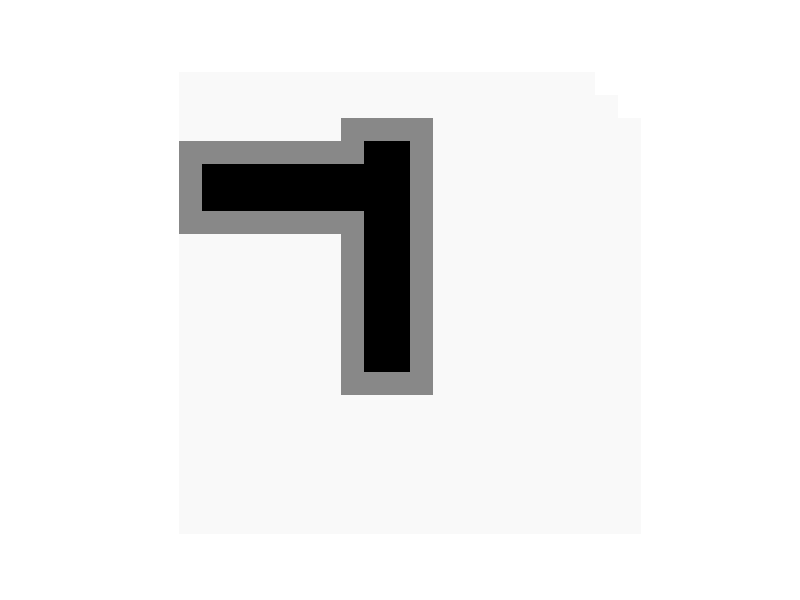

In [45]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Problem specific parameters
GRIDSIZE = 20

def puddlecost(x):
    ''' puddlecost : int -> int

        puddlecost(x) returns the cost for the puddle area corresponding to state x:
        * if x is in the dark puddle area, it returns 1;
        * if x is in the light puddle area, it returns 0.5;
        * otherwise, it returns 0.
        
    '''

    i = x // GRIDSIZE
    j = x % GRIDSIZE
    
    if (j in (4, 5) and i in range(1, 8)) or \
       (i in (8, 9) and j in range(3, 13)):
        return 1.0
    
    if (j in range(3, 7) and i in range(0, 9)) or \
       (i in range(7, 11) and j in range(2, 14)):
        return 0.5
    
    return 0

# -- End: puddlecost


np.set_printoptions(threshold=10)


# States
X = [(i, j) for i in range(GRIDSIZE) for j in range(GRIDSIZE)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities and cost
Pu = np.zeros((nX, nX))
Pd = np.zeros((nX, nX))
Pl = np.zeros((nX, nX))
Pr = np.zeros((nX, nX))

c = np.zeros((nX, nA))

for x in range(nX):
    (i, j) = X[x]
    
    xu = X.index((i, max(j - 1, 0)))
    xd = X.index((i, min(j + 1, GRIDSIZE - 1)))
    xl = X.index((max(i - 1, 0), j))
    xr = X.index((min(i + 1, GRIDSIZE - 1), j))
    
    # Successfull transition
    Pu[x, xu] += 0.92
    Pd[x, xd] += 0.92
    Pl[x, xl] += 0.92
    Pr[x, xr] += 0.92

    # Failed transition (stays in place)
    Pu[x, x] += 0.02
    Pd[x, x] += 0.02
    Pl[x, x] += 0.02
    Pr[x, x] += 0.02

    # Failed transition (oposite direction)
    Pu[x, xd] += 0.02
    Pd[x, xu] += 0.02
    Pl[x, xr] += 0.02
    Pr[x, xl] += 0.02

    # Failed transition (sideways)
    Pu[x, xl] += 0.02
    Pu[x, xr] += 0.02
    Pd[x, xl] += 0.02
    Pd[x, xr] += 0.02
    Pl[x, xu] += 0.02
    Pl[x, xd] += 0.02
    Pr[x, xu] += 0.02
    Pr[x, xd] += 0.02
    
    if x not in (GRIDSIZE * (GRIDSIZE - 2), GRIDSIZE * (GRIDSIZE - 1), GRIDSIZE * (GRIDSIZE - 1) + 1):
        c[x, :] = min(0.05 + puddlecost(x), 1)
    
P = [Pu, Pd, Pl, Pr]

# Discount
gamma = 0.95

# Observe cost function
plt.figure()
plt.imshow(c[:, 0].reshape(GRIDSIZE, GRIDSIZE).T, cmap='Greys', origin='upper')
plt.axis('off')
plt.show()

---

#### Activity 1.        

Compute the optimal $Q$-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [46]:
#lec.19 -- 55

import time

J = np.zeros((nX,nA))
err = 1
i = 0

time0 = time.time()

while err > 1e-8:
    QU = c + gamma * Pu.dot(J)
    QD = c + gamma * Pd.dot(J)    
    QL = c + gamma * Pl.dot(J)    
    QR = c + gamma * Pr.dot(J)
    Jnew = np.min((QU,QD,QL,QR), axis=0)
    err = np.linalg.norm(Jnew-J)
    i+=1
    J = Jnew

Q =  np.zeros((nX,nA))
Q[:,0] = QU[:,0]
Q[:,1] = QD[:,0]
Q[:,2] = QL[:,0]
Q[:,3] = QR[:,0]
time = time.time() - time0
    
print(Q)
print('\ntime:', time)
print(i,'iterations')

[[0.66620905 0.68217222 0.66620905 0.64867778]
 [0.66785408 0.70889182 0.68381725 0.66734816]
 [0.69667515 1.20781559 0.72174972 0.70663337]
 ...
 [0.60463209 0.64360831 0.63873085 0.62468735]
 [0.62676187 0.6632013  0.65874275 0.64568283]
 [0.64725131 0.66476979 0.67693514 0.66476979]]

time: 0.15358638763427734
252 iterations


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [89]:
def greedyAction(Q,x,e=0.1):
    pi = np.zeros((nX,nA))    
    Qx = Q[x,:]
    rand = np.random.uniform(0, 1)
    if rand > e:
        minQ = min(Qx)
        mins = []
        for a in range(0,nA):
            if Qx[a] == minQ:
                mins.append(a)
        a = np.random.choice(mins)
        return a
    else:
        a = np.random.choice(nA)
        return a

#print(greedyAction(Q,0))

### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for $500,000$ iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the vehicle to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal $Q$-function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

<IPython.core.display.Javascript object>


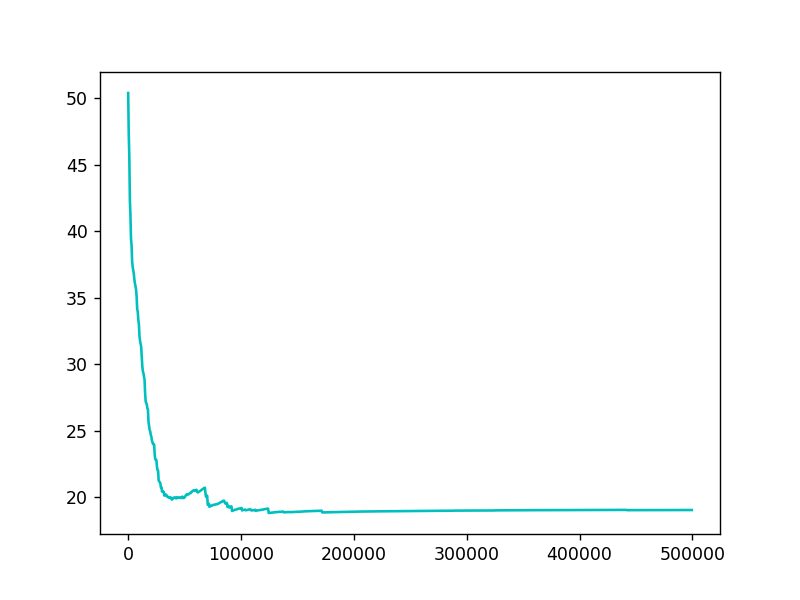


time: 659.5457727909088


In [95]:
import time

time0 = time.time()

pu = np.identity(nX)
pd = np.identity(nX)
pl = np.identity(nX)
pr = np.identity(nX)

p = np.array([pu, pd, pl, pr])

C = np.zeros((nX, nA))

x = np.random.randint(0, nX-1)

Qmb = np.zeros((nX,nA))

occurrencesU = np.zeros(nX)
occurrencesD = np.zeros(nX)
occurrencesL = np.zeros(nX)
occurrencesR = np.zeros(nX)
occurrences = np.array([occurrencesU,occurrencesD,occurrencesL,occurrencesR])

diffMB = []
loops = []

plt.figure()

for loop in range(0,500000):
#for loop in range(0,50000): 
    a = greedyAction(Qmb,x)
    
    if  c[x,a] == 0:
        next_x = np.random.choice(np.arange(0, nX))
    else:
        next_x = np.random.choice(np.arange(0, nX), p=P[a][x])
        
    cost = c[next_x,a]
    
    occurrences[a,x] += 1
    Nxa = occurrences[a,x]
    alpha = 1 / (Nxa + 1)
    
    p[a][x,next_x] = p[a][x,next_x] + alpha * (1 -  p[a][x,next_x])
    for ox in range(0,nX):
        if ox != next_x:
            p[a][x,ox] = (1 - alpha) * p[a][x,ox]
    
    C[x,a] = C[x,a] + alpha * (c[x,a] - C[x,a])
    

    minQ = np.min((Qmb[:,[0]],Qmb[:,[1]],Qmb[:,[2]],Qmb[:,[3]]),axis=0)
    Qmb[x,a] = C[x,a] + gamma * p[a][x].dot(minQ)
    
    x = next_x
    
    if loop % 500 == 0:
        
        diff = np.linalg.norm(Q-Qmb)
        diffMB.append(diff)
        loops.append(loop)
        

plt.plot(loops,diffMB,'-',color='c')
plt.show()

time = time.time() - time0
print('\ntime:', time)
    

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the $Q$-learning algorithm with a learning rate $\alpha=0.3$.

---

<IPython.core.display.Javascript object>


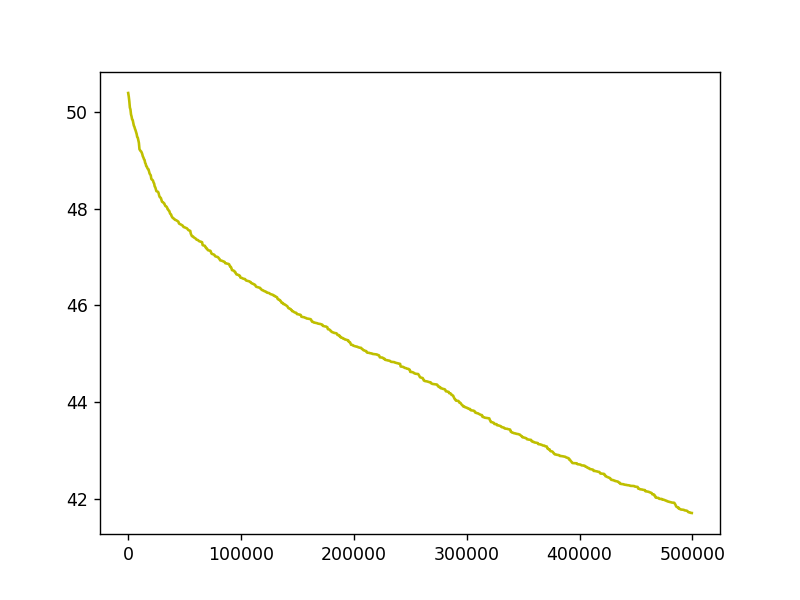


time: 56.54079341888428


In [97]:
import time

alpha = 0.3
time0 = time.time()

x =  np.random.choice(nX)

Qql = np.zeros((nX,nA))

diffQL = []
loopsQL = []

plt.figure()

for loop in range(0,500000):
#for loop in range(0,50000):
    a = greedyAction(Q,x)
    next_x = np.random.choice(np.arange(0, nX), p=P[a][x])

    Qql[x,a] = Qql[x,a] + alpha * (c[x,a] + gamma * min(Qql[next_x, :]) - Qql[x,a])
    
    if  c[x,a] == 0:
        next_x = np.random.choice(nX)
    x = next_x
    
    if loop % 500 == 0:
        diff = np.linalg.norm(Q - Qql)
        diffQL.append(diff)
        loopsQL.append(loop)

plt.plot(loopsQL,diffQL,'-', color='y')       

plt.show()
time = time.time() - time0
print('\ntime:', time)

---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

<IPython.core.display.Javascript object>


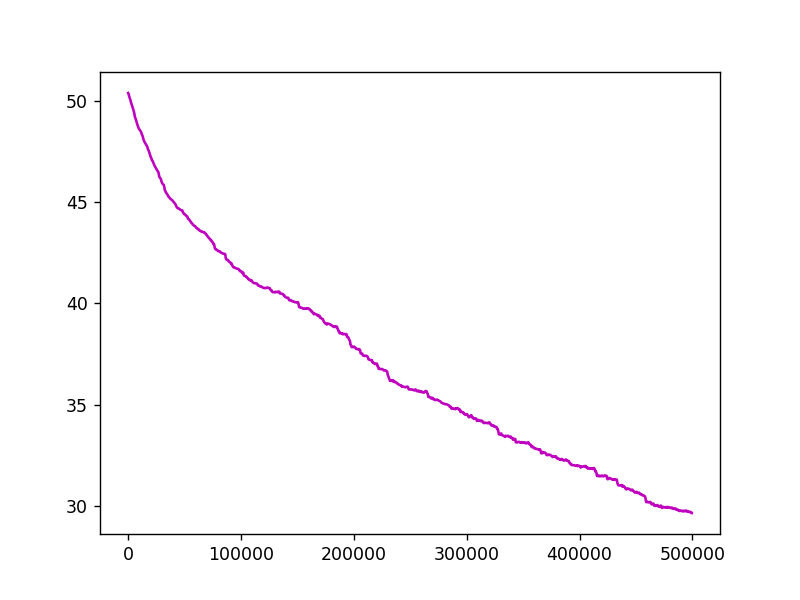


time: 52.03184413909912


In [98]:
import time

alpha = 0.3
time0 = time.time()

pu = np.identity(nX)
pd = np.identity(nX)
pl = np.identity(nX)
pr = np.identity(nX)

p = np.array([pu, pd, pl, pr])

C = np.zeros((nX, nA))

x = np.random.randint(0, nX-1)

Qsa = np.zeros((nX,nA))

loopsSA = []
diffSA = []

plt.figure()

a = greedyAction(Q,x)

for loop in range(0,500000):
#for loop in range(0,50000):

    
    if  c[x,a] == 0:
        next_x = np.random.choice(np.arange(0, nX))
    else:
        next_x = np.random.choice(np.arange(0, nX), p=P[a][x])
    
    next_a = greedyAction(Q,next_x)
        
    ct = c[x,a]
    Qsa[x,a] = Qsa[x,a] + alpha * (ct + gamma * Qsa[next_x, next_a] - Qsa[x,a])

    a = next_a 
    x = next_x
    
    if loop % 500 == 0:
        diff = np.linalg.norm(Q - Qsa)
        diffSA.append(diff)
        loopsSA.append(loop)

plt.plot(loopsSA,diffSA,'-', color='m')
plt.show()
time = time.time() - time0
print('\ntime:', time)

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

<IPython.core.display.Javascript object>


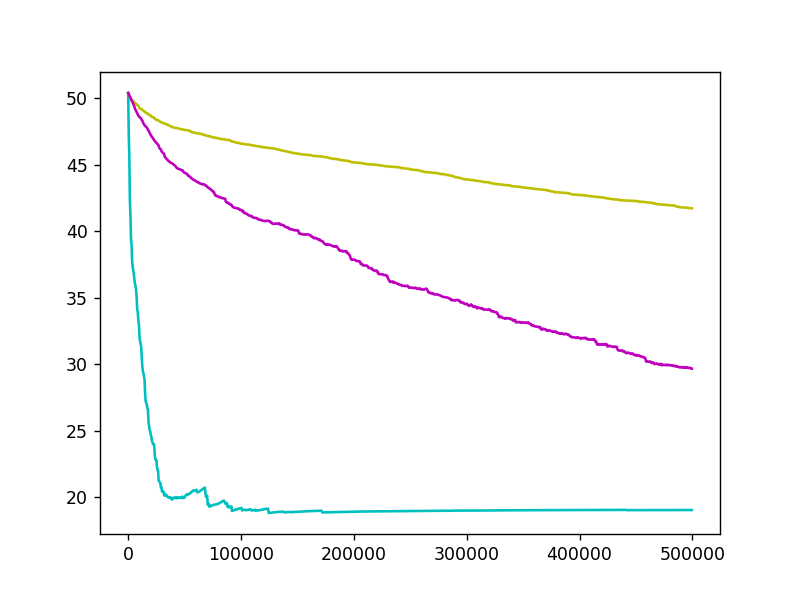

In [99]:
plt.figure()
plt.plot(loops,diffMB,'-', color='c')
plt.plot(loopsQL,diffQL,'-', color='y')
plt.plot(loopsSA,diffSA,'-', color='m')
plt.show()

# Comments:

#### The results we obtained were not what we expected.
We expected for the difference |Q*-Q| of the 3 methods to converge to a value closer to 0, meaning that the Q value obtained was  closer to the optimal Q-function computed in activity 1.

Because this did not happen with 500.000 iterations we think that with a bigger number of iterations we might be able to reach a value closer to the optimal Q-function. In particular with the Q-learning and the SARSA methods, because the value hadn't stabilized yet (as it happened with the model based method after around 50.000 iterations)


With 500.000 iterations the Model based method was the one that reached a value of Q closer to optimal Q-function.



### Model based - activity 3 
Method that interleaves steps of model learning with steps of value/policy iteration
In the model-based approach the transition probabilities and the costs converge to the true parameters P and c as the number of visits of every (x,a) pair reaches infinity.

Based on the plot: this is the approach that 'learns faster', because the curve in the graph reaches a lower level of the difference |Q*-Q| faster (around 50000 iterations)


### Q-learning - activity 4 
Off-policy RL method that learns the value of a policy while following a different policy.

### SARSA - activity 5 
On-policy RL method that learns the value of the policy the agent is following.


##### Q-learning and SARSA
The Q-learning and SARSA methods have similar curves in the graph because the learning method is similar, but...

The SARSA method takes into consideration the next action, this allows to find the next cost value, rather than assuming that the optimal action will be taken and that it resultes in the lowest cost (Q-learning).

In terms of memory: the SARSA method takes into account the control policy of the agent during learning. It means that information needs to be stored longer before the action values can be updated.